In [1]:
import pandas as pd
import glob
import os

# List directories containing the Excel files
directories = [
    r"C:\project_data\results\lower_bound\IMDB-BINARY",
    r"C:\project_data\results\lower_bound\PROTEINS",
    r"C:\project_data\results\lower_bound\AIDS"
]

# Collect all Excel file paths from directories
all_files = []
for directory in directories:
    files = glob.glob(os.path.join(directory, "*.xlsx"))
    all_files.extend(files)

# Read each Excel file and combine them into one DataFrame
df_list = []
for file in all_files:
    temp_df = pd.read_excel(file)
    df_list.append(temp_df)
df = pd.concat(df_list, ignore_index=True)

# Filter to only use datasets AIDS and IMDB-BINARY
datasets = ["AIDS", "IMDB-BINARY", "PROTEINS"]
df = df[df["Dataset"].isin(datasets)]

# Compute total pairs per dataset (used for calculating percentages)
total_pairs = df.groupby("Dataset").size()

def create_pivot_table(threshold):
    # Filter for skipped pairs above the given threshold
    skipped_df = df[df["Lower Bound"] > threshold]

    # Create a pivot table with count of skipped pairs for each heuristic and dataset
    pivot_count = pd.pivot_table(
        skipped_df,
        index="Heuristic",
        columns="Dataset",
        aggfunc='size',
        fill_value=0
    )

    # Ensure both datasets exist in the pivot columns (if one is missing add it)
    for ds in datasets:
        if ds not in pivot_count.columns:
            pivot_count[ds] = 0

    # Order the columns (AIDS, IMDB-BINARY)
    pivot_count = pivot_count[datasets]

    # Create a copy for percentages
    pivot_pct = pivot_count.copy().astype(float)
    #for ds in datasets:
        #pivot_pct[ds] = (pivot_pct[ds] / total_pairs[ds]) * 100

    # Add a new column with Total Skipped (absolute count, not percentage)
    pivot_pct["Total Skipped"] = pivot_count.sum(axis=1)
    return pivot_count


In [2]:
# Create the second pivot table for threshold 50
pivot_table_50 = create_pivot_table(50)
print("\nPivot table with threshold 50 (percentages with absolute 'Total Skipped'):")
print(pivot_table_50)


Pivot table with threshold 50 (percentages with absolute 'Total Skipped'):
Dataset                                        AIDS  IMDB-BINARY  PROTEINS
Heuristic                                                                 
Combined Basic (Node+Edge Count Difference)  323890       211515    341544
Degree Distribution Difference                    0         1327     48881
Edge Count Difference                        116884       187449    253809
Edge Overlap Difference                      262831       425243    506926
Node Count Difference                         69711         5201    130507
Node Label Mismatch                               2            0     47900


In [3]:
import os
import xml.etree.ElementTree as ET

def compute_graph_size(gxl_path):
    """
    Parses a GXL file and calculates its size as a tuple.
    The size is defined by the number of unique nodes and edges.
    """
    try:
        tree = ET.parse(gxl_path)
        root = tree.getroot()
    except Exception as e:
        print(f"Error parsing {gxl_path}: {e}")
        return (0, 0)

    graph_elem = root.find('graph')
    if graph_elem is None:
        print(f"No graph element found in {gxl_path}")
        return (0, 0)

    # Using node 'id' attributes to ensure uniqueness
    node_ids = {node.get("id") for node in graph_elem.findall('node')}
    # For edges, simply count unique edge elements (could be modified if edges need further uniqueness criteria)
    edge_ids = set()
    for edge in graph_elem.findall('edge'):
        # Create a tuple of sorted 'from' and 'to' attributes for undirected uniqueness if available.
        src = edge.get("from")
        tgt = edge.get("to")
        if src is not None and tgt is not None:
            edge_ids.add(tuple(sorted((src, tgt))))
        else:
            edge_ids.add(edge)

    num_nodes = len(node_ids)
    num_edges = len(edge_ids)
    return num_nodes + num_edges

def compute_pair_size(graph_id_1, graph_id_2, gxl_directory):
    """
    Given the ids of two graphs and the directory where the GXL files are stored,
    this function loads `graph_id_1.gxl` and `graph_id_2.gxl`, computes each individual
    size (number of unique nodes and edges), and returns their mean as a tuple.
    """
    path1 = os.path.join(gxl_directory, f"{graph_id_1}.gxl")
    path2 = os.path.join(gxl_directory, f"{graph_id_2}.gxl")

    size1 = compute_graph_size(path1)
    size2 = compute_graph_size(path2)

    return (size1 + size2) / 2.0

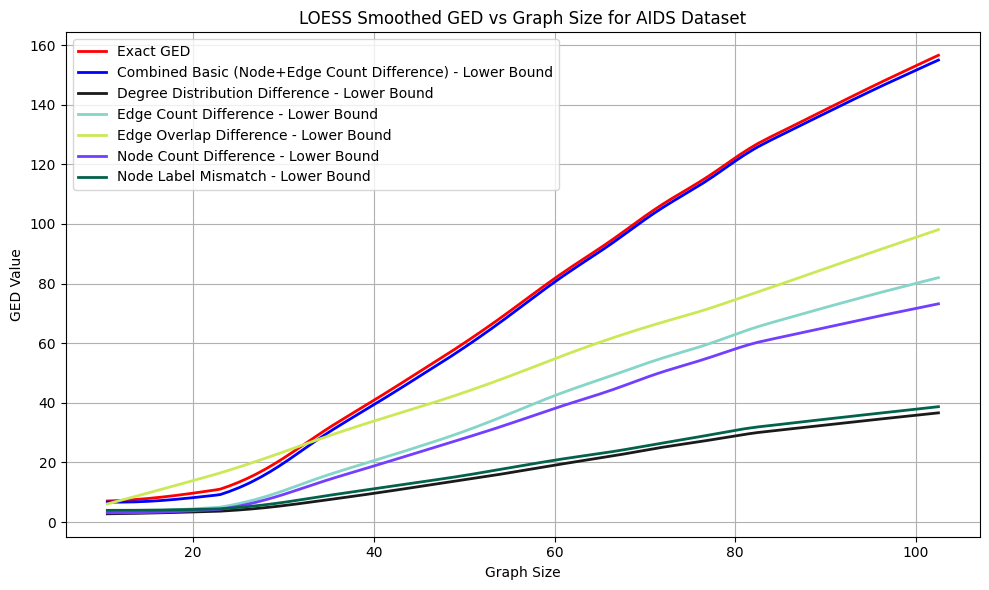

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

# --- Step 1: Read the Exact GED File for the AIDS Dataset ---
file_aids = r"C:\project_data\results\exact_ged\AIDS\merged\results.xlsx"
df_aids = pd.read_excel(file_aids)
df_aids["Dataset"] = "AIDS"
df_aids.rename(columns={"graph_id_1": "graph_id1", "graph_id_2": "graph_id2"}, inplace=True)

# Filter out rows where min_ged is NaN or equal to 0.
df_aids = df_aids[df_aids["min_ged"].notna() & (df_aids["min_ged"] != 0)]

# --- Step 2: Merge with the Lower Bound Data ---
# 'df' is assumed to be the pre-existing DataFrame with lower bound estimations,
# containing: "Dataset", "graph_id1", "graph_id2", "Lower Bound", and "Heuristic".
merged_df = pd.merge(df, df_aids, on=["Dataset", "graph_id1", "graph_id2"], how="inner")
merged_df = merged_df[merged_df["Dataset"] == "AIDS"]

# --- Step 3: Compute Graph Sizes ---
# Set the gxl_directory manually.
gxl_directory = r"C:\project_data\processed_data\gxl\AIDS"
# Assume the function compute_pair_size(graph_id1, graph_id2, gxl_directory) exists.
merged_df["graph_size"] = merged_df.apply(lambda row: compute_pair_size(
    row["graph_id1"], row["graph_id2"], gxl_directory), axis=1)

# --- Step 4: Group Data by Graph Size (Taking Mean for Each Graph Size) ---
exact_grouped = merged_df.groupby("graph_size")["min_ged"].mean().reset_index().sort_values("graph_size")

heuristics = merged_df["Heuristic"].unique()

# Default colors for heuristics (we'll override "Combined Basic" below):
heuristic_colors = ["#c392ec", "#1a1a1a", "#85d5c8", "#cbe957", "#723eff", "#03624c"]

# --- Step 5: Apply LOESS Smoothing ---
from statsmodels.nonparametric.smoothers_lowess import lowess

smoothing_frac = 0.3  # Smoothing fraction for LOESS

# Smooth Exact GED values (red).
smoothed_exact = lowess(
    endog=exact_grouped["min_ged"],
    exog=exact_grouped["graph_size"],
    frac=smoothing_frac
)

# Smooth the lower bound values for each heuristic.
smoothed_heuristics = {}
for heuristic in heuristics:
    subdata = merged_df[merged_df["Heuristic"] == heuristic].copy()
    subdata_grouped = (
        subdata.groupby("graph_size")["Lower Bound"]
        .mean()
        .reset_index()
        .sort_values("graph_size")
    )
    smoothed = lowess(
        endog=subdata_grouped["Lower Bound"],
        exog=subdata_grouped["graph_size"],
        frac=smoothing_frac
    )
    smoothed_heuristics[heuristic] = smoothed

# --- Step 6: Plot the LOESS Curves ---
plt.figure(figsize=(10, 6))

# Plot Exact GED as a red LOESS curve (no markers).
plt.plot(
    smoothed_exact[:, 0],
    smoothed_exact[:, 1],
    label="Exact GED",
    color="red",
    linewidth=2
)

# Plot each heuristic, overriding color for "Combined Basic" to blue.
for idx, heuristic in enumerate(heuristics):
    # If it's "Combined Basic", force color to be blue.
    if heuristic == "Combined Basic (Node+Edge Count Difference)":
        color = "blue"
    else:
        color = heuristic_colors[idx % len(heuristic_colors)]

    smoothed = smoothed_heuristics[heuristic]
    plt.plot(
        smoothed[:, 0],
        smoothed[:, 1],
        label=f"{heuristic} - Lower Bound",
        color=color,
        linewidth=2
    )

plt.xlabel("Graph Size")
plt.ylabel("GED Value")
plt.title("LOESS Smoothed GED vs Graph Size for AIDS Dataset")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd

# Dictionary of dataset names and file paths
ged_files = {
    "AIDS": r"C:\project_data\results\exact_ged\AIDS\merged\results.xlsx",
    "IMDB-BINARY": r"C:\project_data\results\exact_ged\IMDB-BINARY\merged\results.xlsx",
    "PROTEINS": r"C:\project_data\results\exact_ged\PROTEINS\merged\results.xlsx"
}

# Dictionary to store the mean and maximum of min_ged for each dataset
stats_min_ged = {}

# Iterate over the datasets and calculate the mean and maximum of min_ged
for dataset, file_path in ged_files.items():
    df = pd.read_excel(file_path)
    # Drop rows with missing values in the min_ged column
    df_valid = df.dropna(subset=["min_ged"])
    mean_value = df_valid["min_ged"].mean()
    max_value = df_valid["min_ged"].max()
    stats_min_ged[dataset] = {"mean": mean_value, "max": max_value}

# Print the mean and maximum values per dataset
print("Mean and Maximum min_ged per dataset:")
for dataset, stats in stats_min_ged.items():
    print(f"{dataset}: Mean = {stats['mean']}, Max = {stats['max']}")

Mean and Maximum min_ged per dataset:
AIDS: Mean = 16.488027779367712, Max = 153
IMDB-BINARY: Mean = 52.922048997772826, Max = 626
PROTEINS: Mean = 63.312523079763665, Max = 670
